# Проект: классификация

In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import warnings
import category_encoders as ce
import optuna

from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.feature_selection import SelectKBest, f_classif

In [181]:
warnings.filterwarnings('ignore')
plt.style.use('dark_background')
pio.renderers.default = 'png'

In [182]:
# Зададим константы для всего проекта
RANDOM_STATE = 42
N_JOBS = -1

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1. Исследование явных пропущенных значений

In [183]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [184]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
df.isna().sum().sort_values(ascending=False).reset_index().rename(columns={'index': 'feature', 0: 'nulls'})

,feature,nulls
0,balance,25
1,age,0
2,day,0
3,poutcome,0
4,previous,0
5,pdays,0
6,campaign,0
7,duration,0
8,month,0
9,contact,0


### Задание 2. Исследование признака job на скрытые пропущенные значения.

In [185]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

`unknown` - скрытые пропущенные значения.

### Задание 3. Преобразование `balance` в тип `float`

In [186]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)

df['balance'] = df['balance'].apply(
    lambda balance: str(balance).replace('$', '').replace(' ', '').replace(',', '.')
).astype(float)
# Среднее значение преобразованного признака
round(df['balance'].mean(), 3)

1529.129

### Задание 4. Заполнение пропусков в `balance` медианой признака

In [187]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
balance_median = df['balance'].median()
df['balance'].fillna(balance_median, inplace=True)
# Среднее значение признака после заполнения пропусков
round(df['balance'].mean(), 3)

1526.936

### Задание 5. Заполнение пропусков в `job` и `education` модой признаков

In [188]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
job_mode = df['job'].mode()[0]
edu_mode = df['education'].mode()[0]
# Заполням неявные пропуски
df['job'] = df['job'].apply(
    lambda job: job_mode if 'unknown' in job else job
)
df['education'] = df['education'].apply(
    lambda edu: edu_mode if 'unknown' in edu else edu
)
# Узнаем средний баланс клиентов с самой частовстречающейся профессией и самым частовстречающимся образованием
grouped = df.groupby(by=['job', 'education'], as_index=False)['balance'].mean()
mask = (grouped['job'] == job_mode) & (grouped['education'] == edu_mode)
grouped[mask]

,job,education,balance
13,management,secondary,1598.882979


### Задание 6. Удаление выбросов из признака `balance`

In [189]:
Q3 = df['balance'].quantile(0.25)
Q1 = df['balance'].quantile(0.75)

# Межквартильный размах
IQR = Q3 - Q1

# Верхняя и нижняя границы
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

# Округление границ до целых чисел
upper_bound_rounded = int(np.ceil(upper_bound))
lower_bound_rounded = int(np.floor(lower_bound))

print(f'Верхняя граница: {upper_bound_rounded}')
print(f'Нижняя граница: {lower_bound_rounded}')

Верхняя граница: -2241
Нижняя граница: 4063


In [190]:
# удалите все выбросы для признака balance
# ваш код
def tukey_clean(dataframe:pd.DataFrame, column:str, left=1.5, right=1.5):
    
    """Returns cleaned dataframe using Tukey method

    Args:
        `dataframe` (pd.DataFrame): pandas.DataFrame object
        `column` (str): numeric column in dataframe to clean
        `left` (float, optional): left bound parameter. Defaults to 1.5.
        `right` (float, optional): right bound parameter. Defaults to 1.5.

    Returns:
        `DataFrame`: cleaned dataframe
    """
    
    q_1 = dataframe[column].quantile(0.25)
    q_3 = dataframe[column].quantile(0.75)
    iqr = q_3 - q_1
    left_bound = q_1 - left*iqr
    upper_bound = q_3 + right*iqr
    mask = (dataframe[column] >= left_bound) & (dataframe[column] <= upper_bound)
    return dataframe[mask]

df = tukey_clean(df, 'balance')
df.shape

(10105, 17)

## Часть 2:  Разведывательный анализ

### Задание 1. Сколько клиентов открыли депозит?

deposit
no     5424
yes    4681
Name: count, dtype: int64

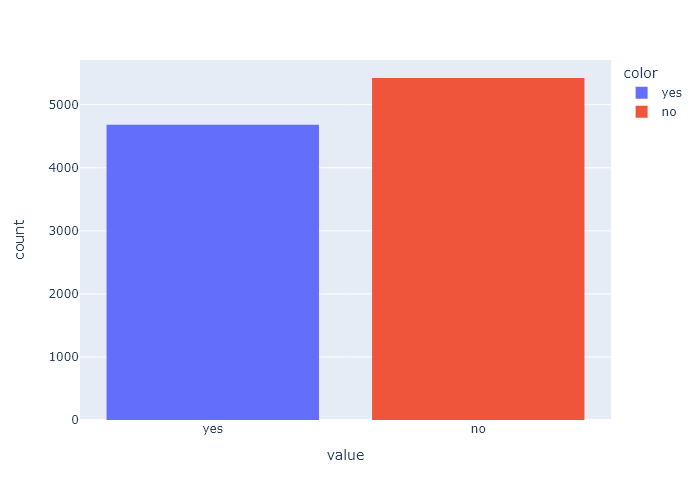

In [191]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
display(df['deposit'].value_counts()),
fig = px.histogram(
    df['deposit'],
    color=df['deposit']
)
fig.show()

### Задания 2 и 3. Описательные статистики для количественных признаков

In [192]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
df.describe(exclude=object).T

,count,mean,std,min,25%,50%,75%,max
age,10105.0,40.895497,11.734931,18.0,32.0,38.0,48.0,95.0
balance,10105.0,807.653538,994.151966,-2049.0,95.0,445.0,1227.0,4063.0
day,10105.0,15.590302,8.441510,1.0,8.0,15.0,22.0,31.0
duration,10105.0,368.742603,346.651524,2.0,137.0,252.0,490.0,3881.0
campaign,10105.0,2.517170,2.707159,1.0,1.0,2.0,3.0,43.0
pdays,10105.0,51.319644,109.644179,-1.0,-1.0,-1.0,2.0,854.0
previous,10105.0,0.816230,2.243795,0.0,0.0,0.0,1.0,58.0


`age:`

* Наибольший возраст клиента банка - 95 лет
* Медиана от среднего несильно отличается, выбросы не наблюдаются. Возраст подавляющего большинства клиентов - около 40 лет

`balance:`

* Наибольшая задолженность у клиента составляет 2049,00 $
* Наибольший баланс у клиента составляет 4063,00 $
* В основном баланс составляет от ~ 100 до 1200 (IQR)

`day:`

* Чаще всего банк контактирует с клиентом в 15-й день месяца, то есть в середине месяца.

`duration:`

* У большинства клиентов (IQR) продолжительность разговора с представителем банка составляет от ~130 до ~500 секунд

`campaign:`

* В течение текущей компании с клиентами обычно контактируют не более 3-ёх раз

### Задания 4 и 5. Описательные статистики для категориальных признаков. Визуализация

In [193]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты
df.describe(include=object).T

,count,unique,top,freq
job,10105,11,management,2315
marital,10105,3,married,5715
education,10105,3,secondary,5517
default,10105,2,no,9939
housing,10105,2,no,5243
loan,10105,2,no,8712
contact,10105,3,cellular,7283
month,10105,12,may,2617
poutcome,10105,4,unknown,7570
deposit,10105,2,no,5424


`job:`

* Всего уникальных работ у клиентов - 11
* Наиболее встречающаяся - мэнэджмент

`marital:`

* Наибольшее число клиентов женаты или замужем

`education:`

* В основном у клиентов среднее образование

`contact:`

* Чаще всего с клиентами связываются с помощью сотовой связи

`poutcome:`

* У многих клиентов результат прошлой маркетинговой кампании недоступен, скорее всего этот признак неинформативен, т.к. имеет слишком много неизвестных значений

In [194]:
df['month'].value_counts().reset_index()

,month,count
0,may,2617
1,jul,1418
2,aug,1385
3,jun,1104
4,apr,830
5,nov,780
6,feb,709
7,oct,335
8,jan,319
9,sep,278


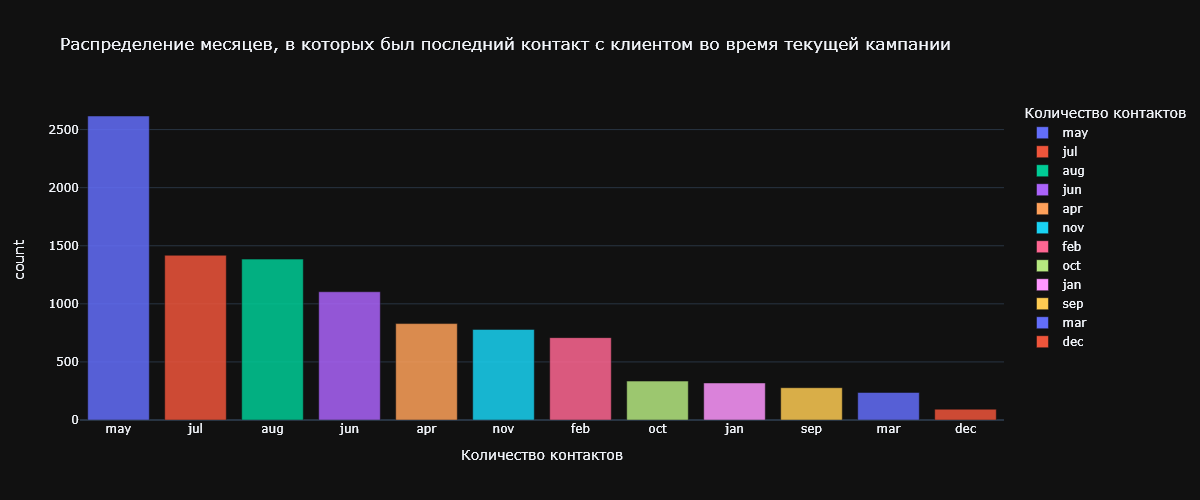

In [195]:
px.bar(
    df['month'].value_counts().reset_index(),
    x='month',
    y='count',
    template='plotly_dark',
    color='month',
    width=1200,
    height=500,
    opacity=0.85,
    title='Распределение месяцев, в которых был последний контакт с клиентом во время текущей кампании',
    labels={'index': 'Месяц', 'month': 'Количество контактов'}
)

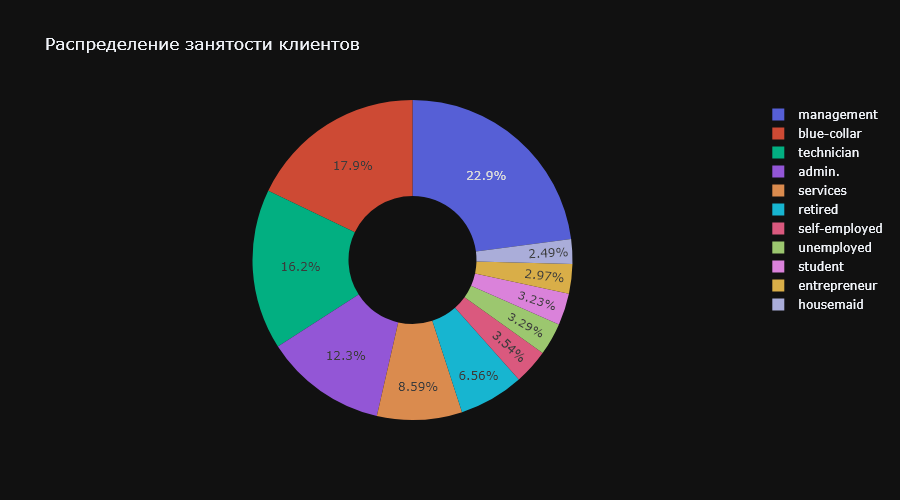

In [219]:
px.pie(
    df,
    names='job',
    template='plotly_dark',
    width=900,
    height=500,
    opacity=0.85,
    title='Распределение занятости клиентов',
    hole=0.4
)

### Задание 6. Визуализация зависимости конверсии от статуса в прошлой кампании

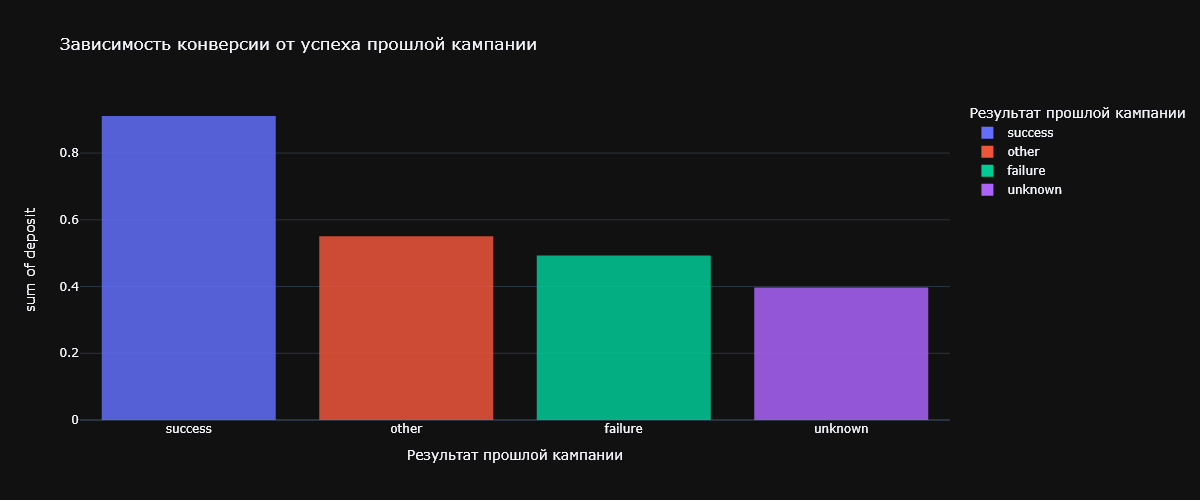

In [220]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
# Создадим дополнительный датафрейм, чтобы было удобнее визуализировать графики
extra_df = df[['poutcome', 'month', 'age', 'marital', 'education', 'job', 'deposit']]
extra_df['deposit'] = extra_df['deposit'].apply(lambda deposit: int('yes' in deposit))
# Считаем конверсию для каждого статуса
conversion = extra_df.groupby(by=['poutcome'], as_index=False)['deposit'].mean().sort_values(by=['deposit'], ascending=False)
# Визуализируем
px.histogram(
    conversion,
    x='poutcome',
    y='deposit',
    color='poutcome',
    template='plotly_dark',
    width=1200,
    height=500,
    title='Зависимость конверсии от успеха прошлой кампании',
    opacity=0.85,
    labels={'poutcome': 'Результат прошлой кампании'}
)

### Задание 7. Визуализация зависимости конверсии от месяца

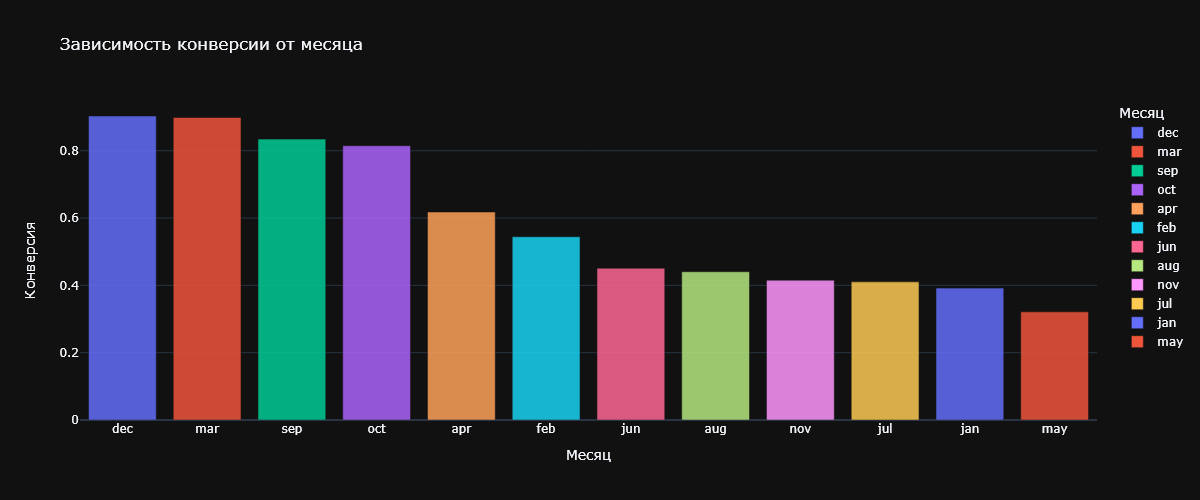

In [221]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
conversion = extra_df.groupby(by=['month'], as_index=False)['deposit'].mean().sort_values(by='deposit', ascending=False)
px.bar(
    conversion,
    x='month',
    y='deposit',
    template='plotly_dark',
    width=1200,
    height=500,
    opacity=0.85,
    color='month',
    title='Зависимость конверсии от месяца',
    labels={'month': 'Месяц', 'deposit': 'Конверсия'}
)

Май является менее подходящим месяцем, чтобы предлагать клиентам открыть депозит.

### Задание 8. Визуализация зависимости конверсии от возрастной категории клиентов

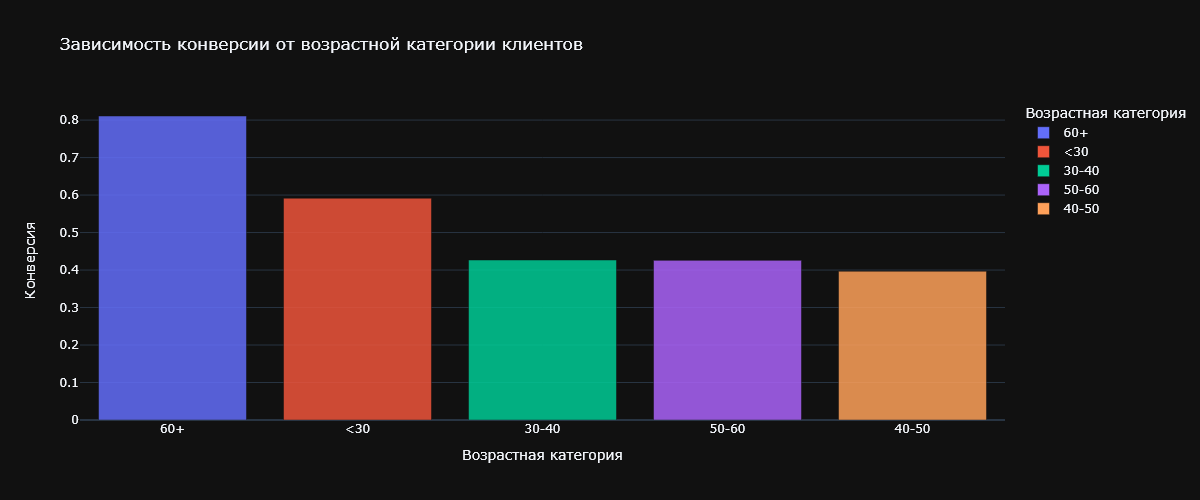

In [222]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
# Функция для кодирования возраста в категориальный признак
def encode_age(age:int):
    age_dict = {
        range(30): '<30',
        range(30, 41): '30-40',
        range(40, 51): '40-50',
        range(50, 61): '50-60',
        range(60, 100): '60+'
    }
    for key in age_dict.keys():
        if age in key:
            return age_dict[key]
# Создадим признак с категорией возраста
extra_df['age_category'] = extra_df['age'].apply(encode_age)
# Группируем
conversion = extra_df.groupby(by=['age_category'], as_index=False)['deposit'].mean().sort_values(by='deposit', ascending=False)
# Строим график
px.bar(
    conversion,
    x='age_category',
    y='deposit',
    color='age_category',
    template='plotly_dark',
    width=1200,
    height=500,
    opacity=0.85,
    title='Зависимость конверсии от возрастной категории клиентов',
    labels={'age_category': 'Возрастная категория', 'deposit': 'Конверсия'}
)

### Задания 9 и 10. Визуализация зависимости конверсии от семейного положения и образования

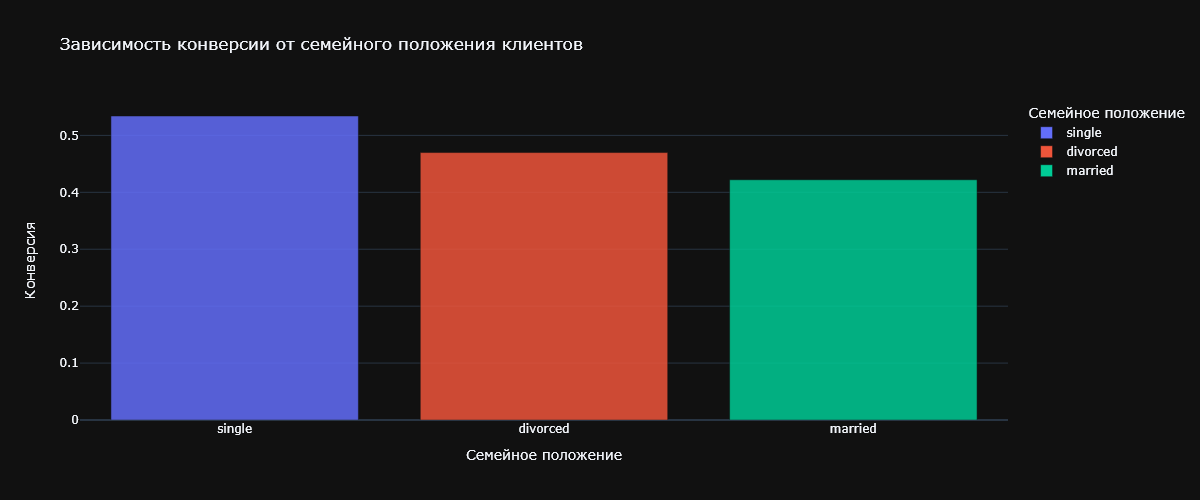

In [223]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
conversion = extra_df.groupby(by=['marital'], as_index=False)['deposit'].mean().sort_values(by='deposit', ascending=False)
px.bar(
    conversion,
    x='marital',
    y='deposit',
    color='marital',
    template='plotly_dark',
    width=1200,
    height=500,
    opacity=0.85,
    title='Зависимость конверсии от семейного положения клиентов',
    labels={'marital': 'Семейное положение', 'deposit': 'Конверсия'}
)

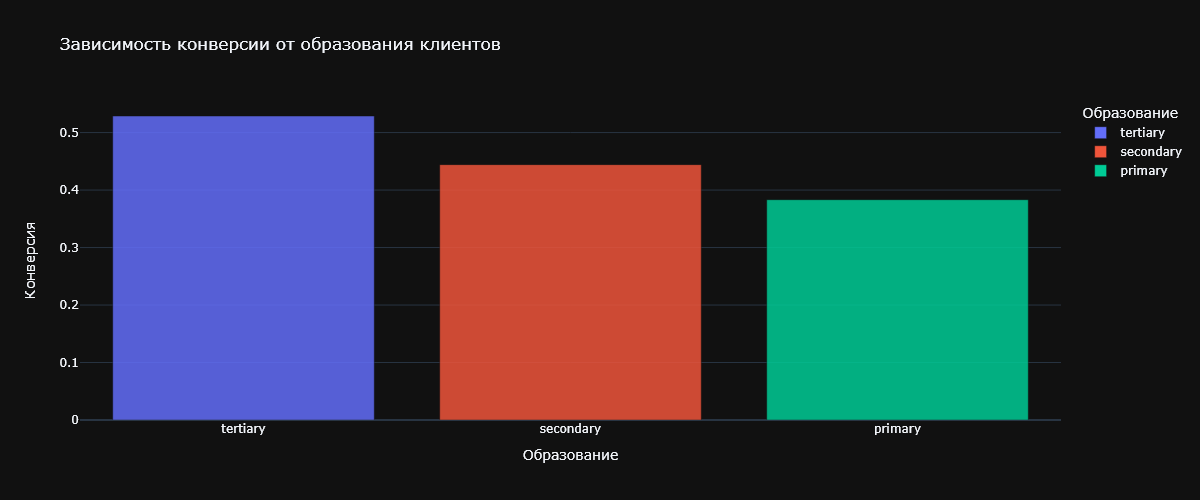

In [224]:
conversion = extra_df.groupby(by=['education'], as_index=False)['deposit'].mean().sort_values(by='deposit', ascending=False)
px.bar(
    conversion,
    x='education',
    y='deposit',
    color='education',
    template='plotly_dark',
    width=1200,
    height=500,
    opacity=0.85,
    title='Зависимость конверсии от образования клиентов',
    labels={'education': 'Образование', 'deposit': 'Конверсия'}
)

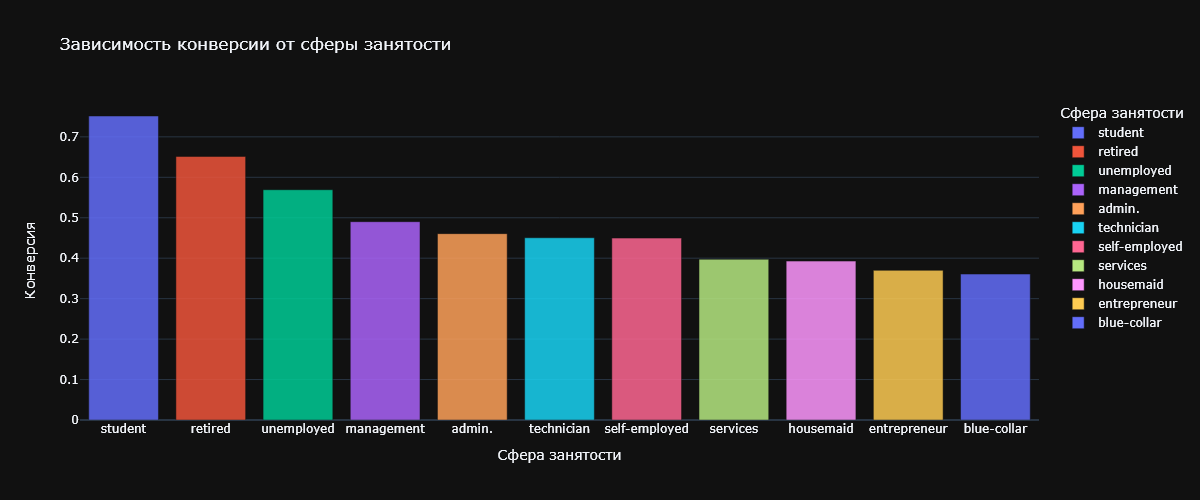

In [225]:
conversion = extra_df.groupby(by=['job'], as_index=False)['deposit'].mean().sort_values(by='deposit', ascending=False)
px.bar(
    conversion,
    x='job',
    y='deposit',
    color='job',
    template='plotly_dark',
    width=1200,
    height=500,
    opacity=0.85,
    title='Зависимость конверсии от сферы занятости',
    labels={'job': 'Сфера занятости', 'deposit': 'Конверсия'}
)

In [229]:
df['job'].value_counts()

job
management       2315
blue-collar      1807
technician       1638
admin.           1246
services          868
retired           663
self-employed     358
unemployed        332
student           326
entrepreneur      300
housemaid         252
Name: count, dtype: int64

### Задание 11

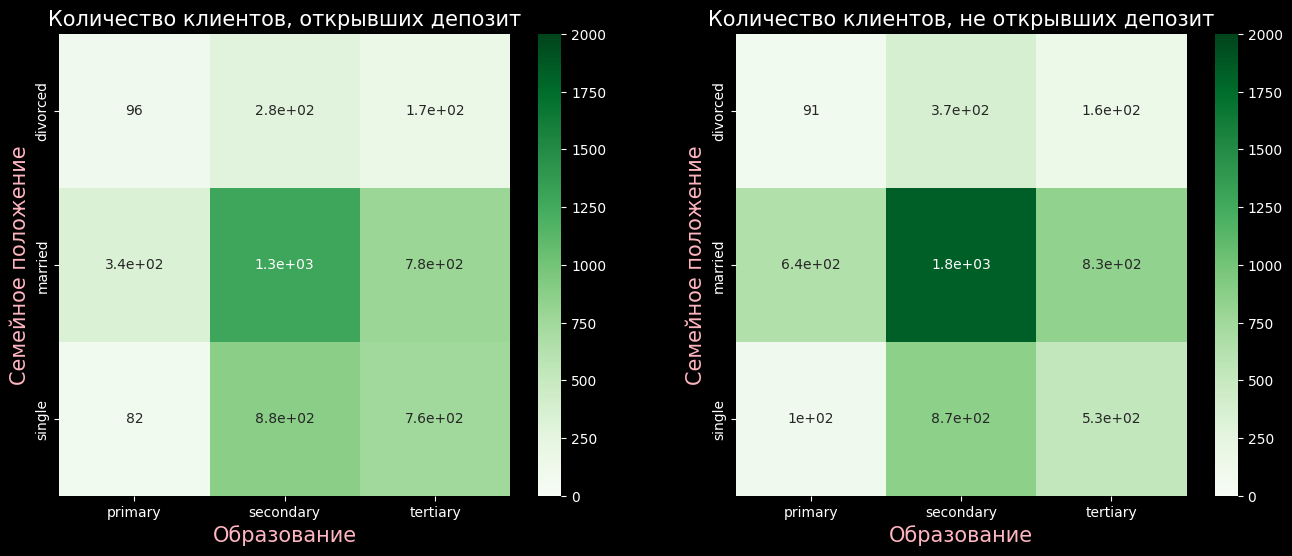

In [230]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
# Разделим датафрейм на клиентов, открывших и не открывших депозит
positive_grouped = extra_df[extra_df['deposit'] == 1]
negative_grouped = extra_df[extra_df['deposit'] == 0]
# Сделаем сводные таблицы для разделенных клиентов по признакам образования и семейного положения
positive_pivot = positive_grouped.pivot_table(
    values='deposit',
    aggfunc='count',
    index='marital',
    columns='education'
)
negative_pivot = negative_grouped.pivot_table(
    values='deposit',
    aggfunc='count',
    index='marital',
    columns='education'
)
# Визуализируем 2 тепловые карты для каждой категории
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.heatmap(positive_pivot, annot=True, ax=axes[0], vmax=2000, vmin=0, cmap='Greens').set_title('Количество клиентов, открывших депозит', fontsize=15)
sns.heatmap(negative_pivot, annot=True, ax=axes[1], vmax=2000, vmin=0, cmap='Greens').set_title('Количество клиентов, не открывших депозит', fontsize=15)
axes[0].set_ylabel('Семейное положение', fontsize=15, color='lightpink')
axes[0].set_xlabel('Образование', fontsize=15, color='lightpink')
axes[1].set_ylabel('Семейное положение', fontsize=15, color='lightpink')
axes[1].set_xlabel('Образование', fontsize=15, color='lightpink');

Наиболее популярные группы для открывших и не открывших депозит клиентов не отличаются. Вероятно, это связано с тем, что в данных преобладают клиенты следующего пересечения категорий - married & secondary

## Часть 3: преобразование данных

### Задание 1

In [203]:
# преобразуйте уровни образования

### Задания 2 и 3

In [204]:
# преобразуйте бинарные переменные в представление из нулей и единиц

### Задание 4

In [205]:
# создайте дамми-переменные

### Задания 5 и 6

In [206]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

### Задания 7 и 8

In [207]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [208]:
# рассчитайте необходимые показатели

### Задание 9

In [209]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

### Задание 10

In [210]:
# нормализуйте данные с помощью minmaxsxaler

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [211]:
# обучите логистическую регрессию и рассчитайте метрики качества

### Задания 2,3,4

In [212]:
# обучите решающие деревья, настройте максимальную глубину

### Задание 5

In [213]:
# подберите оптимальные параметры с помощью gridsearch

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [214]:
# обучите на ваших данных случайный лес

### Задания 2 и 3

In [215]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

### Задание 4

In [216]:
# объедините уже известные вам алгоритмы с помощью стекинга 

### Задание 5

In [217]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задания 6,7,8

In [218]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna